In [5]:
from pyspark.sql import SparkSession
SparkSession.builder.master("local[*]").getOrCreate().stop()

In [8]:
spark = SparkSession.builder.getOrCreate()

# Data Ingestion - load Data and Show samples

In [42]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType

# Load large transactions data
transactions_df = spark.read.csv("large_transactions.csv",header ="true")

# Load large customer feedback data
feedback_df = spark.read.csv("large_customer_feedback.csv",header ="true")

# Load large inventory data
# Define the schema for json file
schema = StructType([
    StructField("product_id", IntegerType(), False),
    StructField("product_name", StringType(), True),
    StructField("stock_level", IntegerType(), True),
    StructField("price", FloatType(), True)
])
inventory_df = spark.read.option("multiline","true").schema(schema).json("large_inventory.json")

# Display a sample of each dataset
transactions_df.show(3)
inventory_df.show(3)
feedback_df.show(3)


+--------------+-------+----------+--------+------+----------------+
|transaction_id|user_id|product_id|quantity|amount|transaction_date|
+--------------+-------+----------+--------+------+----------------+
|             1|   5388|      9152|       9|305.67|      2023-01-07|
|             2|  31656|      5763|       1|184.31|      2023-05-16|
|             3|  36725|      4733|       4|  7.66|      2023-01-20|
+--------------+-------+----------+--------+------+----------------+
only showing top 3 rows

+----------+------------+-----------+------+
|product_id|product_name|stock_level| price|
+----------+------------+-----------+------+
|         1|   Product_1|         61| 91.89|
|         2|   Product_2|        553|  9.75|
|         3|   Product_3|        328|182.89|
+----------+------------+-----------+------+
only showing top 3 rows

+-------+----------+------+--------------------+-----------+
|user_id|product_id|rating|              review|review_date|
+-------+----------+------+---

# Data Cleaning and Transformation with RDDs

In [43]:
# Convert transactions DataFrame to RDD
transactions_rdd = transactions_df.rdd
#print(type(transactions_rdd.take(1)))
#transactions_rdd.take(3)

#function to check if a record is valid
def is_valid(record):
    return record['transaction_id'] is not None and record['transaction_id'] !='' and record['amount'] is not None and record['amount'] != ''

#filter out invalid records
cleaned_transactions_rdd = transactions_rdd.filter(is_valid)
cleaned_records = cleaned_transactions_rdd.take(5)

#print("cleaned_records:")
#for record in cleaned_records:
#    print(record)




In [44]:
import hashlib
from pyspark.sql import Row

# Write Function to Anonymize user IDs using Hashing
def anonymize(record):
    return Row(
        transaction_id=record.transaction_id,
        user_id=hashlib.sha256(record.user_id.encode()).hexdigest(),
        product_id=record.product_id,
        quantity=record.quantity,
        amount=record.amount,
        transaction_date=record.transaction_date
    )
#Aplly the hashing function to each record
anonymized_rdd = cleaned_transactions_rdd.map(anonymize)
anonymized_records = anonymized_rdd.take(5)

#show user_id after being hashed
#for record in anonymized_records:
#    print(record["user_id"])

# convert rdd back to dataframe
cleaned_transactions_df = cleaned_transactions_rdd.toDF()

# Display cleaned and anonymized data
cleaned_transactions_df.show(5)

+--------------+-------+----------+--------+------+----------------+
|transaction_id|user_id|product_id|quantity|amount|transaction_date|
+--------------+-------+----------+--------+------+----------------+
|             1|   5388|      9152|       9|305.67|      2023-01-07|
|             2|  31656|      5763|       1|184.31|      2023-05-16|
|             3|  36725|      4733|       4|  7.66|      2023-01-20|
|             4|  22713|      4207|       1|411.73|      2023-04-19|
|             5|  74067|      1914|       5|499.21|      2023-08-17|
+--------------+-------+----------+--------+------+----------------+
only showing top 5 rows



# DataFrame Operations for Cleaning and Transformation

In [51]:
from pyspark.sql.functions import col, lower, trim

# Clean inventory data by handling missing values and normalizing text
cleaned_inventory_df = inventory_df.dropna(subset=["stock_level"])\
                                  .withColumn("product_name", lower(trim(col("product_name"))))

cleaned_inventory_df.show(4)

#perform a join operation to combine data (inventory and transactions)
joined_df = cleaned_inventory_df.join(cleaned_transactions_df,on='product_id',how='inner')
joined_df.show(8)


+----------+------------+-----------+------+
|product_id|product_name|stock_level| price|
+----------+------------+-----------+------+
|         1|   product_1|         61| 91.89|
|         2|   product_2|        553|  9.75|
|         3|   product_3|        328|182.89|
|         4|   product_4|        347|148.38|
+----------+------------+-----------+------+
only showing top 4 rows

+----------+------------+-----------+------+--------------+-------+--------+------+----------------+
|product_id|product_name|stock_level| price|transaction_id|user_id|quantity|amount|transaction_date|
+----------+------------+-----------+------+--------------+-------+--------+------+----------------+
|      9152|product_9152|        871| 238.7|             1|   5388|       9|305.67|      2023-01-07|
|      5763|product_5763|        252| 91.52|             2|  31656|       1|184.31|      2023-05-16|
|      4733|product_4733|        235| 33.22|             3|  36725|       4|  7.66|      2023-01-20|
|      42

# Spark SQL Queries

In [57]:
# Create temporary views for SQL queries
cleaned_transactions_df.createOrReplaceTempView("transactions")
cleaned_inventory_df.createOrReplaceTempView("inventory")
joined_df.createOrReplaceGlobalTempView("joined_data")

#query: Top 10 most purshased products in the last month
filtered_df = joined_df.filter(f.col("transaction_date") >= "2023-12-1")
top_products_df = filtered_df.groupBy("product_name").agg(f.count("*").alias("purshase_count")).orderBy(f.desc("purshase_count"))


#top_products_df = spark.sql("""select product_name, COUNT(*) from joined_data where transaction_date >= '2023-12-01'\
#            group BY product_name ORDER BY purchase_count DESC LIMIT 10  """)



top_products_df.show(5)

+------------+--------------+
|product_name|purshase_count|
+------------+--------------+
| product_629|            17|
|product_8334|            16|
|product_7350|            16|
|product_1085|            15|
| product_895|            15|
+------------+--------------+
only showing top 5 rows



In [60]:
# Query: Monthly revenue trends
monthly_revenue_df = spark.sql(""" select YEAR(transaction_date) as Y ,Month(transaction_date) as M
            ,COUNT(amount) as monthly_revenue
            from transactions 
            group by Y, M 
            order by M""")

monthly_revenue_df.show()

+----+---+---------------+
|   Y|  M|monthly_revenue|
+----+---+---------------+
|2023|  1|          85136|
|2023|  2|          77283|
|2023|  3|          85246|
|2023|  4|          82698|
|2023|  5|          84790|
|2023|  6|          82539|
|2023|  7|          84771|
|2023|  8|          84557|
|2023|  9|          81936|
|2023| 10|          85441|
|2023| 11|          82950|
|2023| 12|          82653|
+----+---+---------------+



In [65]:
# Query: Inventory turnover rates

total_sales_df = transactions_df.groupBy("product_id").agg(f.sum("quantity").alias("total_quantity_sold"))

average_inventory_df = inventory_df.groupBy("product_id").agg(f.avg("stock_level")\
                                        .alias("average_inventory"))

turnover_df = total_sales_df.join(average_inventory_df, on="product_id")
# Calculate inventory turnover rate
turnover_df = turnover_df.withColumn(
    "inventory_turnover_rate",
    f.col("total_quantity_sold") / f.col("average_inventory")
)

turnover_df.show()

+----------+-------------------+-----------------+-----------------------+
|product_id|total_quantity_sold|average_inventory|inventory_turnover_rate|
+----------+-------------------+-----------------+-----------------------+
|      4937|              476.0|            936.0|     0.5085470085470085|
|      2069|              545.0|            749.0|     0.7276368491321762|
|      3606|              651.0|            736.0|     0.8845108695652174|
|      5325|              615.0|            460.0|     1.3369565217391304|
|      2904|              538.0|            379.0|     1.4195250659630607|
|      2162|              538.0|            736.0|     0.7309782608695652|
|      9586|              643.0|            452.0|     1.4225663716814159|
|      1159|              495.0|            190.0|     2.6052631578947367|
|      7711|              556.0|            103.0|      5.398058252427185|
|       691|              587.0|            111.0|      5.288288288288288|
|       675|             

# Performance Optimization Techniques

In [66]:
from pyspark.sql.functions import broadcast

# Caching DataFrames to optimize performance for multiple transformations
transactions_df.cache()
inventory_df.cache()

# Repartition DataFrames for optimal join performance
transactions_df_repartitioned = transactions_df.repartition("product_id")
inventory_df_repartitioned = inventory_df.repartition("product_id")


# Use Broadcast Join for small DataFrames (if applicable)
joined_df_optimized = transactions_df_repartitioned.join(
    broadcast(inventory_df_repartitioned),
    on="product_id",
    how="inner"  # Adjust join type as needed
)

# Display the optimized joined DataFrame
joined_df_optimized.show(5)

+----------+--------------+-------+--------+------+----------------+------------+-----------+------+
|product_id|transaction_id|user_id|quantity|amount|transaction_date|product_name|stock_level| price|
+----------+--------------+-------+--------+------+----------------+------------+-----------+------+
|      4937|            30|  60843|       2|350.98|      2023-06-18|Product_4937|        936|180.73|
|      2069|           209|  33561|       4|110.38|      2023-10-09|Product_2069|        749|351.35|
|      3606|           462|  60912|       4|477.52|      2023-10-26|Product_3606|        736|242.68|
|      5325|           468|   3507|       3|330.94|      2023-02-08|Product_5325|        460| 26.47|
|      2904|          1083|   1078|       6| 25.47|      2023-03-27|Product_2904|        379|345.25|
+----------+--------------+-------+--------+------+----------------+------------+-----------+------+
only showing top 5 rows



# Store the Transformed Data

In [67]:
output_path = "/user/student/sparkETL_data"

# Save DataFrame in Parquet format
joined_df_optimized.write.mode("overwrite").parquet(output_path)


joined_df_optimized.write.mode("overwrite").option("compression", "snappy").parquet(output_path)


# Top Products Bar Chart

In [70]:
#prepare the data
top_products_df = joined_df_optimized.groupBy("product_name").agg(
    f.sum("quantity").alias("total_sales")
).orderBy(f.desc("total_sales")).limit(10)

top_products_df.show()


+------------+-----------+
|product_name|total_sales|
+------------+-----------+
|Product_4360|      836.0|
|Product_1970|      788.0|
|Product_2710|      786.0|
|Product_7075|      779.0|
|Product_4670|      769.0|
|Product_5735|      765.0|
|Product_4316|      764.0|
|Product_3738|      764.0|
|Product_6342|      763.0|
|Product_4957|      760.0|
+------------+-----------+



# Revenue Trend Line Chart

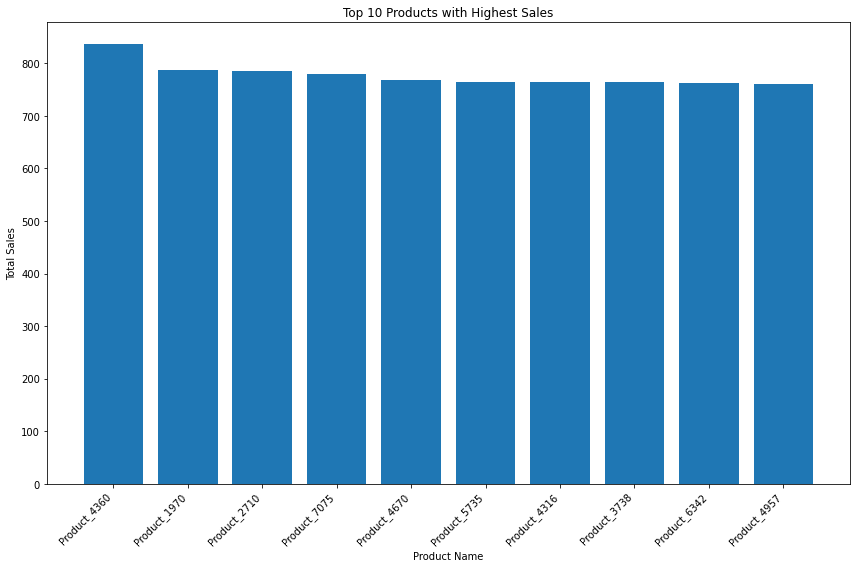

In [73]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert to Pandas DataFrame for plotting
top_products_pd = top_products_df.toPandas()

# Plot
plt.figure(figsize=(12, 8))
plt.bar(top_products_pd['product_name'], top_products_pd['total_sales'])
plt.xlabel('Product Name')
plt.ylabel('Total Sales')
plt.title('Top 10 Products with Highest Sales')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
